In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

import jax.random as jr
import jax.numpy as jnp
from jax import nn, lax

from pymdp.jax.agent import Agent as AIFAgent
from pymdp.envs import TMazeEnv
# from pymdp import simulate_behaviour

from pybefit.inference import run_nuts, run_svi

from pybefit.inference.numpyro.models import NumpyroModel, NumpyroGuide
from pybefit.inference import Normal, NormalGamma, RegularisedHorseshoe
from pybefit.inference.numpyro.likelihoods import pymdp_likelihood as likelihood

from numpyro.infer.autoguide import AutoNormal, AutoMultivariateNormal
from numpyro.infer import Predictive

%matplotlib inline
rng_key = jr.PRNGKey(101)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [2]:
def simulate_behaviour(agents, task, options):
    Nt = options['num_trials']
    Nb = options['num_blocks']
    Na = options['num_agents']

    measurements = {'actions': [], 'outcomes': []}
    for nb in range(Nb):

        _obs = task.reset() # reset the environment and get an initial observation
        # broadcast the same observation to all agents
        obs = jnp.broadcast_to(jnp.array(_obs), (Na, len(_obs)))

        emp_prior = agents.D

        measurements["actions"].append([])
        measurements["outcomes"].append([obs])
        for nt in range(Nt):
            qs = agents.infer_states(obs, emp_prior)
            q_pi, _ = agents.infer_policies(qs)
            actions = agents.sample_action(q_pi)
            emp_prior = agents.update_empirical_prior(actions, qs)

            measurements["actions"][-1].append( actions )
            
            obs = []
            for a in actions:
                obs.append( jnp.array(task.step(list(a))) )
            obs = jnp.stack(obs)
            measurements["outcomes"][-1].append(obs)
        
        # TODO: learning step at the end of a mini-block
    
    actions = []
    for a in measurements['actions']:
        actions.append(jnp.stack(a).astype(jnp.int32))

    measurements['actions'] = jnp.stack(actions).astype(jnp.int32)

    obs = []
    for o in measurements['outcomes']:
        obs.append(jnp.stack(o))
    
    measurements['outcomes'] = jnp.stack(obs)[:, :Nt]

    return measurements

reward_probabilities = [0.98, 0.02] # probabilities used in the original SPM T-maze demo
task = TMazeEnv(reward_probs=reward_probabilities)

A_gp = task.get_likelihood_dist()
B_gp = task.get_transition_dist()
controllable_indices = [0]

In [3]:
num_params = 3
num_agents = 20
prior = NormalGamma(num_params, num_agents, backend='numpyro')

# transform generative process matrices to jax arrays
B_gm = [jnp.array(b) for b in B_gp]
A_gm = [jnp.array(a) for a in A_gp]

def transform(z):
    # map z variables to model parameters
    
    na, np = z.shape
    
    assert np == 3  # test that we have only 3 parameters
    
    a = nn.sigmoid(z[..., 0])  # element of the likelihood matrix
    lam = jnp.exp(z[..., 1])  # preference for positive outcomes
    d = nn.sigmoid(z[..., 2])  # prior state probability

    C = [
        jnp.zeros((na, 4)),
        jnp.expand_dims(lam, -1) * jnp.array([0., 1., -1.]),
        jnp.zeros((na, 2))
    ]

    D = [jnp.broadcast_to(nn.one_hot(0, 4), (na, 4)), jnp.stack([d, 1-d], -1)]
    
    # we do not compute gradients through these model parameters
    A = lax.stop_gradient([jnp.broadcast_to(a, (na,) + a.shape) for a in A_gm])
    B = lax.stop_gradient([jnp.broadcast_to(b, (na,) + b.shape) for b in B_gm])
    E = lax.stop_gradient(jnp.ones((na, 4))/4)

    # replace first component of A with parameterised likelihood matrix

    a1 = jnp.stack([a, 1 - a], -1)
    a2 = jnp.stack([1 - a, a], -1)

    middle_matrix1 = jnp.stack([jnp.zeros((na, 2)), a1, a2], -2)
    middle_matrix2 = jnp.stack([jnp.zeros((na, 2)), a2, a1], -2)

    side_vector = jnp.stack([jnp.array([1.0, 0., 0.]), jnp.array([1.0, 0., 0.])], -1)
    side_vector = jnp.broadcast_to(side_vector, (na, 3, 2))
    
    A[1] = jnp.stack([side_vector, middle_matrix1, middle_matrix2, side_vector], -2)
    
    # return the aif agent class
    agent = AIFAgent(A, B, C, D, E, control_fac_idx=controllable_indices)
    return agent

rng_key, _rng_key = jr.split(rng_key)
z = jr.normal(_rng_key, shape=(num_agents, num_params))/10

z = Predictive(prior, num_samples=1)(_rng_key)['z'][0]

agents = transform(z)

task = TMazeEnv()

opts_task = {
    'num_blocks': 10,
    'num_trials': 2,
    'num_agents': num_agents
}

# generate behavioural data
measurments = simulate_behaviour(agents, task, opts_task)

In [4]:
from pybefit.inference.methods import default_dict_numpyro_nuts

opts_model = {
    'prior': {},
    'transform': {},
    'likelihood': opts_task
}

model = NumpyroModel(prior, transform, likelihood, opts=opts_model)

In [5]:
# perform inference using no-u-turn sampler
# opts sampling dictionary can be used to specify various parameters
# either for the NUTS kernel or MCMC sampler
opts_sampling = default_dict_numpyro_nuts
print(opts_sampling)

samples, mcmc = run_nuts(model, measurments, opts=opts_sampling)

{'seed': 0, 'num_samples': 1000, 'num_warmup': 100, 'sampler_kwargs': {'kernel': {}, 'mcmc': {'progress_bar': True}}}


sample: 100%|██████████| 1100/1100 [30:36<00:00,  1.67s/it, 511 steps of size 8.26e-03. acc. prob=0.73] 


/home/dima/.conda/envs/befit/lib/python3.10/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 1000 posterior samples and 400 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -599.49     0.96
p_loo        0.86        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      210   52.5%
 (0.5, 0.7]   (ok)         60   15.0%
   (0.7, 1]   (bad)        39    9.8%
   (1, Inf)   (very bad)   91   22.8%



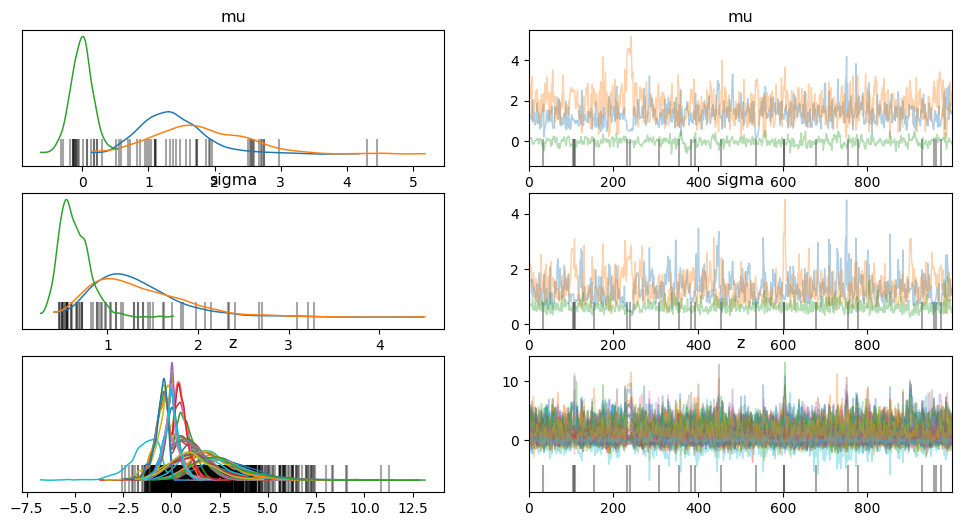

In [6]:
# we can use arviz for evaluating the quality of the inference or model evidence

idata = az.from_numpyro(mcmc)
print( az.loo(idata) )

az.plot_trace(idata, var_names=("mu", "sigma", "z"));

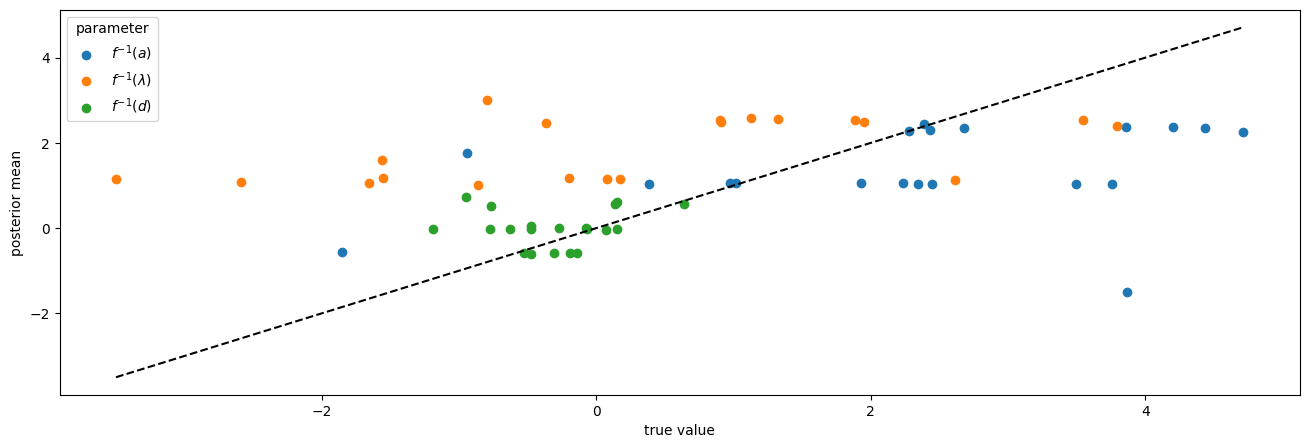

In [7]:
plt.figure(figsize=(16, 5))
labels = [r'$f^{-1}(a)$', r'$f^{-1}(\lambda)$', r'$f^{-1}(d)$']
for i in range(3):
    plt.scatter(z[:, i], samples['z'].mean(0)[:, i], label=labels[i])
    
plt.plot((z.min(), z.max()), (z.min(), z.max()), 'k--')
plt.ylabel('posterior mean')
plt.xlabel('true value')
plt.legend(title='parameter')

In [8]:
from pybefit.inference.methods import default_dict_numpyro_svi

posterior = NumpyroGuide(AutoNormal(prior))

# perform inference using stochastic variational inference
opts_svi = default_dict_numpyro_svi
print(opts_svi)

samples, svi, results = run_svi(model, posterior, measurments, opts=opts_svi)

{'seed': 0, 'enumerate': False, 'iter_steps': 10000, 'optim': None, 'optim_kwargs': {'learning_rate': 0.001}, 'elbo_kwargs': {'num_particles': 10, 'max_plate_nesting': 1}, 'svi_kwargs': {'progress_bar': True, 'stable_update': True}, 'sample_kwargs': {'num_samples': 100}}


100%|██████████| 10000/10000 [04:30<00:00, 36.98it/s, init loss: 1012.8724, avg. loss [9501-10000]: 662.6078]


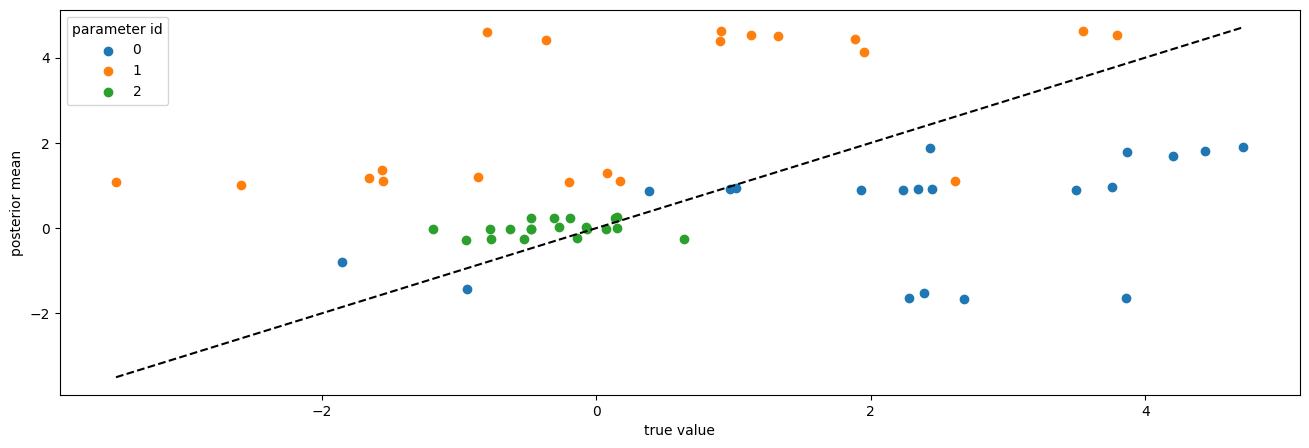

In [9]:
plt.figure(figsize=(16, 5))
for i in range(3):
    plt.scatter(z[:, i], samples['z'].mean(0)[:, i], label=i)
    
plt.plot((z.min(), z.max()), (z.min(), z.max()), 'k--')
plt.ylabel('posterior mean')
plt.xlabel('true value')
plt.legend(title='parameter id')

In [10]:
from pybefit.inference.methods import default_dict_numpyro_svi

posterior = NumpyroGuide(AutoMultivariateNormal(prior))

# perform inference using stochastic variational inference
opts_svi = default_dict_numpyro_svi
print(opts_svi)

samples, svi, results = run_svi(model, posterior, measurments, opts=opts_svi)

{'seed': 0, 'enumerate': False, 'iter_steps': 10000, 'optim': None, 'optim_kwargs': {'learning_rate': 0.001}, 'elbo_kwargs': {'num_particles': 10, 'max_plate_nesting': 1}, 'svi_kwargs': {'progress_bar': True, 'stable_update': True}, 'sample_kwargs': {'num_samples': 100}}


100%|██████████| 10000/10000 [04:27<00:00, 37.40it/s, init loss: 1017.4746, avg. loss [9501-10000]: 654.9091]


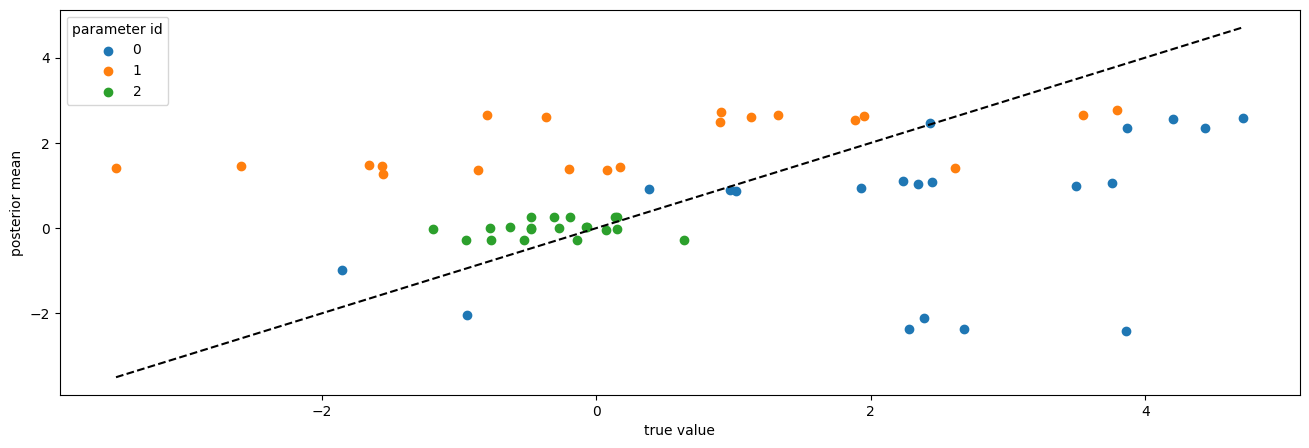

In [11]:
plt.figure(figsize=(16, 5))
for i in range(3):
    plt.scatter(z[:, i], samples['z'].mean(0)[:, i], label=i)
    
plt.plot((z.min(), z.max()), (z.min(), z.max()), 'k--')
plt.ylabel('posterior mean')
plt.xlabel('true value')
plt.legend(title='parameter id')